# Backdoor Unlearning

## Outline

1. Experimental setup (generating configs)
2. Clean model training
3. Poisoned model training
4. First-order unlearning
5. Second-order unlearning
6. Visualizing results


## Experimental Setup

- All configurations to test are defined in the `[train|poison|unlearn].json` files (see below).
- If parameters are passed as list, all their combinations are tested in a grid-search manner.
- Only a single combination is provided for this demo. The original combinations are in `Applications/Poisoning/configs`
- The function generates directories and configuration files for each combination. They are later used by an evaluation script to run the experiment. This allows for parallelization and distributed execution.

In [1]:
import sys
sys.path.append('../')


In [2]:
# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [3]:
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

## Clean Model Training

- Train a clean model for reference.

In [4]:
from Applications.Poisoning.train import main as train

# train one clean and one poisoned model
train(model_folder=model_folder/'clean', target_args='VGG16_Cifar10_fo_clean', model_filename='Cifar10_VGG16_best_model.hdf5')

2024-07-18 01:11:57.119816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/team1337/.local/easybuild_new/software/OpenMPI/4.0.5-GCC-10.2.0/lib:/home/team1337/.local/easybuild_new/software/PMIx/3.1.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libfabric/1.11.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/UCX/1.9.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libevent/2.1.12-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/hwloc/2.2.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libpciaccess/0.16-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/XZ/5.2.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/numactl/2.0.1

model_filename Cifar10_VGG16_best_model.hdf5


2024-07-18 01:12:15.467202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/team1337/.local/easybuild_new/software/OpenMPI/4.0.5-GCC-10.2.0/lib:/home/team1337/.local/easybuild_new/software/PMIx/3.1.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libfabric/1.11.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/UCX/1.9.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libevent/2.1.12-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/hwloc/2.2.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libpciaccess/0.16-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/XZ/5.2.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/numactl/2.0.13-GCCcore-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                        

## Train Poisoned Model

- Select one of the generated configurations and train a poisoned model.
- The poisoning uses an `injector` object which can be persisted for reproducibility. It will inject the backdoors/label noise into the same samples according to a seed. In our experiments, we worked with label noise poisoning.

In [5]:
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config

poisoned_folder = model_folder/'budget-10000'/'seed-42'
poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')
train_poisoned(model_folder=poisoned_folder, target_args='VGG16_Cifar10_fo_clean', poison_kwargs=poison_kwargs, train_kwargs=train_kwargs)

model_filename Cifar10_VGG16_poisoned_model.hdf5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
     

In [6]:
poisoned_weights = poisoned_folder/'best_model.hdf5'       # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'fo_repaired.hdf5'   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'so_repaired.hdf5'   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


## Unlearning

- Perform the first-order and second-order unlearning. The unlearning is wrapped in a function that
    - loads the clean data, saves the original labels
    - injects the poison (label noise)
    - creates difference set Z using `injector.injected_idx`
    - main unlearning happens in `Applications.Poisoning.unlearn.common.py:unlearn_update` and the thereby called `iter_approx_retraining` method
- The variable naming follows the following ideas:
    - `z_x`, `z_y`: features (x) and labels (y) in set `Z`
    - `z_x_delta`, `z_y_delta`: changed features and labels (`z_x == z_x_delta` here and `z_y_delta` contains the original (fixed) labels)
- A word about why iterative:
    - The approximate retraining is configured to unlearn the desired changes in one step.
    - To avoid putting a lot of redundant erroneous samples in the changing set `Z`, the iterative version
        - takes a sub-sample (`prio_idx`) of `hvp_batch_size` in the delta set `Z`
        - makes one unlearning step
        - recalculates the delta set and focuses only on remaining errors
    - The idea here is that similar to learning, it is better to work iteratively in batches since the approximation quality of the inverse hessian matrix decreases with the number of samples included (and the step size)

In [7]:
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')


# fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='VGG16_Cifar10_fo_clean')
# so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs)

In [8]:
from sklearn.metrics import accuracy_score 
from Applications.Poisoning.model import get_VGG16_CIFAR100, get_VGG16_CIFAR10, get_VGG16_SVHN, get_RESNET50_CIFAR10,get_RESNET50_CIFAR100, get_RESNET50_SVHN
from Applications.Poisoning.dataset import Cifar10, SVHN, FashionMnist, Cifar100
import numpy as np

def evaluate(model, data, weights_path):
    (x_train, y_train), (x_test, y_test), (x_val, y_val) = data
    model.load_weights(weights_path)
    y_pred = model.predict(x=x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    acc = accuracy_score(y_true, y_pred)
    return acc

model = get_RESNET50_CIFAR10()
# evaluate(model,data=Cifar10.load(), weights_path=model_folder/'clean'/'Cifar10_RESNET50_best_model.hdf5')

Loading weights from None


**** clean_fo_so_clean ****
Loading weights from None
Accuracy init model :  0.7384
Unlearning results already exist for RESNET50 Cifar10
**** clean_fo_clean_so ****
Loading weights from None
Accuracy init model :  0.7384
Unlearning results already exist for RESNET50 Cifar10
**** clean_fo_fo_clean ****
Loading weights from None
Accuracy init model :  0.7384
 target : feature_extraction
prefix ==: clean_fo_fo_clean
Loading weights from None
From core : target feature_extraction, num_layers 10
From core : num_layers 10 
From core : target feature_extraction, num_layers 10
From core : num_layers 10 
From core : target feature_extraction, num_layers 10
From core : num_layers 10 
From core : target feature_extraction, num_layers 10
From core : num_layers 10 
From core : target feature_extraction, num_layers 10
From core : num_layers 10 
From core : target feature_extraction, num_layers 10
From core : num_layers 10 
From core : target feature_extraction, num_layers 10
From core : num_layers 

../Applications/Poisoning/unlearn/common.py:217: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 10))


From core : target classifier, num_layers 6
From core : num_layers 6 
From core : target classifier, num_layers 6
From core : num_layers 6 
Loading weights from None
Saving results to: /home/ameck.dosseh/conite/MachineUnlearning/models/poisoning/budget-10000/seed-42/first-order/Cifar10_Cifar10_RESNET50_classifier_clean_fo_clean_fo_unlearning_results.json
Results saved to: /home/ameck.dosseh/conite/MachineUnlearning/models/poisoning/budget-10000/seed-42/first-order/Cifar10_Cifar10_RESNET50_classifier_clean_fo_clean_fo_unlearning_results.json
**** clean_fo_fo_fo ****
Loading weights from None
Accuracy init model :  0.7384
 target : both
prefix ==: clean_fo_fo_fo
Loading weights from None
From core : target both, num_layers 16
From core : num_layers 16 
From core : target both, num_layers 16
From core : num_layers 16 
From core : target both, num_layers 16
From core : num_layers 16 
From core : target both, num_layers 16
From core : num_layers 16 
From core : target both, num_layers 16
Fr

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/ameck.dosseh/conite/MachineUnlearning/models/poisoning/budget-10000/seed-42/first-order/RESNET50_Cifar10_classifier-clean_fo_so_fo_repaired_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

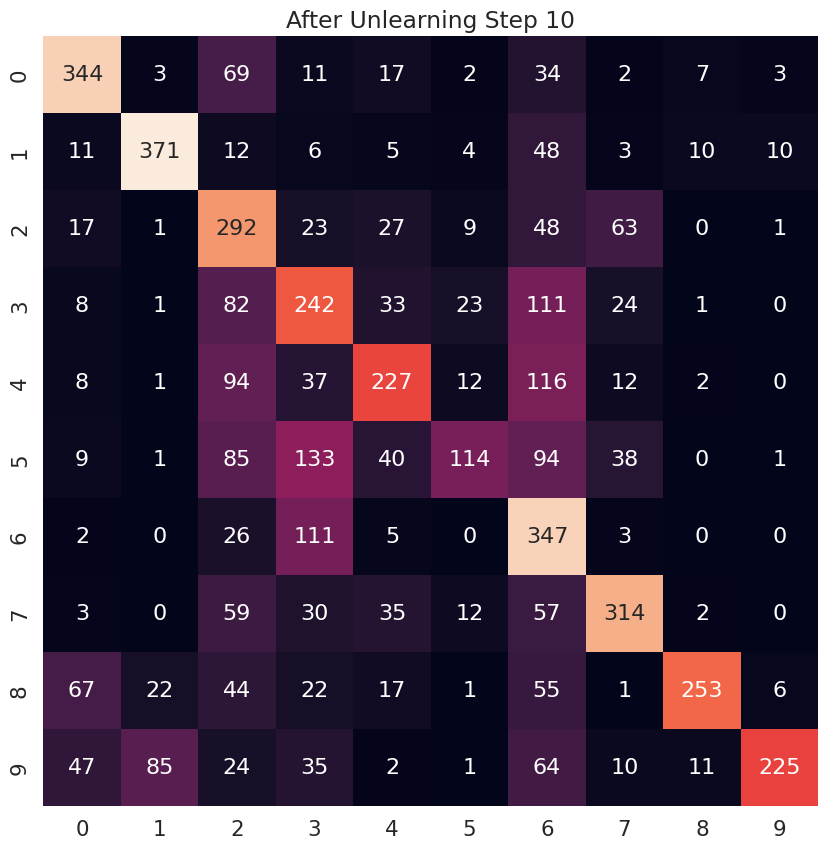

In [9]:
# clean_fo
# target prefix num_layers

path_clean_fo = poisoned_folder/'first-order' /'RESNET50_Cifar10_classifier_clean_fo_repaired_model.hdf5'
# clean_fo_so_clean
print(f"**** clean_fo_so_clean ****") 
train_results = model_folder/'clean'/'Cifar10_RESNET50_train_results.json'
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-clean_fo_so_clean-10', modelweights=path_clean_fo, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_clean_fo_so_clean_repaired_model.hdf5')

# clean_fo_clean_so
print(f"**** clean_fo_clean_so ****") 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_fo_clean_so-6', modelweights=path_clean_fo, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier_clean_fo_clean_so_repaired_model.hdf5')

# clean_fo_fo_clean
print(f"**** clean_fo_fo_clean ****") 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-clean_fo_fo_clean-10', modelweights=path_clean_fo, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_clean_fo_fo_clean_repaired_model.hdf5')

# clean_fo_clean_fo
print(f"**** clean_fo_clean_fo ****") 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_fo_clean_fo-6', modelweights=path_clean_fo, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier_clean_fo_clean_fo_repaired_model.hdf5')

# clean_fo_fo_fo
print(f"**** clean_fo_fo_fo ****") 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_both-clean_fo_fo_fo-16', modelweights=path_clean_fo, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_both_clean_fo_fo_fo_repaired_model.hdf5')

# clean_fo_so_so
print(f"**** clean_fo_so_so ****")
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_both-clean_fo_so_so-16', modelweights=path_clean_fo, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_both_clean_fo_so_so_repaired_model.hdf5')

# clean_fo_so_fo
print(f"**** clean_fo_so_fo ****") 
# take so_clean like path
path_clean_fo_so_clean = poisoned_folder/'second-order' /'RESNET50_Cifar10_feature_extraction_clean_fo_so_clean_repaired_model.hdf5'
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_fo_so_fo-6', modelweights=path_clean_fo_so_clean, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier-clean_fo_so_fo_repaired_model.hdf5')

# clean_fo_fo_so
print(f"**** clean_fo_fo_so ****") 
# take clean_fo_fo_clean like path
path_clean_fo_fo_clean = poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_clean_fo_fo_clean_repaired_model.hdf5'
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_fo_fo_so-6', modelweights=path_clean_fo_fo_clean, train_results=train_results)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier-clean_fo_fo_so_repaired_model.hdf5')


In [ ]:
# # fo_clean
# fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-fo_clean-10')
# evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_fo_clean_repaired_model.hdf5')

# fo_clean
# target prefix num_layers

# fo_clean
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-fo_clean-10')
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier_fo_clean_repaired_model.hdf5')

path_fo_clean = poisoned_folder/'second-order' /'RESNET50_Cifar10_classifier_fo_clean_repaired_model.hdf5'
# fo_clean_so_clean 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-fo_clean_so_clean-10', modelweights=path_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_fo_clean_so_clean_repaired_model.hdf5')

# fo_clean_clean_so 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-fo_clean_clean_so-6', modelweights=path_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier_fo_clean_clean_so_repaired_model.hdf5')

# fo_clean_fo_clean 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-fo_clean_fo_clean-10', modelweights=path_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_fo_clean_fo_clean_repaired_model.hdf5')

# fo_clean_clean_fo 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-fo_clean_clean_fo-10', modelweights=path_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_fo_clean_clean_fo_repaired_model.hdf5')

# fo_clean_fo_fo 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_both-fo_clean_fo_fo-16', modelweights=path_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_both_fo_clean_fo_fo_repaired_model.hdf5')

# fo_clean_so_so 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_both-fo_clean_so_so-16', modelweights=path_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_both_fo_clean_so_so_repaired_model.hdf5')

# fo_clean_so_fo 
# take so_clean like path
path_fo_clean_so_clean = poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_fo_clean_so_clean_repaired_model.hdf5'
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-fo_clean_so_fo-6', modelweights=path_fo_clean_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_both_fo_clean_so_fo_repaired_model.hdf5')

# fo_clean_fo_so 
# take fo_clean_fo_clean like path
path_fo_clean_fo_clean = poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_fo_clean_fo_clean_repaired_model.hdf5'
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-fo_clean_fo_so-6', modelweights=path_fo_clean_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier-fo_clean_fo_so_repaired_model.hdf5')


In [ ]:
# so_clean
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-so_clean-10')
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_so_clean_repaired_model.hdf5')



# # clean-fo
# fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-so_clean-6')
# evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_clean_fo_repaired_model.hdf5')

path_so_clean = poisoned_folder/'second-order' /'RESNET50_Cifar10_classifier_so_clean_repaired_model.hdf5'
# so_clean_so_clean 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-so_clean_so_clean-10', modelweights=path_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_so_clean_so_clean_repaired_model.hdf5')

# so_clean_clean_so 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-so_clean_clean_so-6', modelweights=path_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier_so_clean_clean_so_repaired_model.hdf5')

# so_clean_fo_clean 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-so_clean_fo_clean-10', modelweights=path_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_so_clean_fo_clean_repaired_model.hdf5')

# so_clean_clean_fo 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-so_clean_clean_fo-6', modelweights=path_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier_so_clean_clean_fo_repaired_model.hdf5')

# so_clean_fo_fo 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_both-so_clean_fo_fo-16', modelweights=path_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_both_so_clean_fo_fo_repaired_model.hdf5')

# so_clean_so_so 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_both-so_clean_so_so-16', modelweights=path_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_both_so_clean_so_so_repaired_model.hdf5')

# so_clean_so_fo 
# take so_clean like path
path_so_clean_so_clean = poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_so_clean_so_clean_repaired_model.hdf5'
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-so_clean_so_fo-6', modelweights=path_so_clean_so_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier-so_clean_so_fo_repaired_model.hdf5')

# so_clean_fo_so 
# take so_clean_fo_clean like path
path_so_clean_fo_clean = poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_so_clean_fo_clean_repaired_model.hdf5'
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-so_clean_fo_so-6', modelweights=path_so_clean_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier-so_clean_fo_so_repaired_model.hdf5')


In [ ]:

# clean_so
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_so-6')
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier_clean_so_repaired_model.hdf5')


# # clean-fo
# fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-clean_so-6')
# evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_clean_fo_repaired_model.hdf5')

path_clean_so = poisoned_folder/'second-order' /'RESNET50_Cifar10_classifier_clean_so_repaired_model.hdf5'
# clean_so_so_clean 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-clean_so_so_clean-10', modelweights=path_clean_so)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_clean_so_so_clean_repaired_model.hdf5')

# clean_so_clean_so 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_so_clean_so-6', modelweights=path_clean_so)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier_clean_so_clean_so_repaired_model.hdf5')

# clean_so_fo_clean 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_feature_extraction-clean_so_fo_clean-10', modelweights=path_clean_so)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_feature_extraction_clean_so_fo_clean_repaired_model.hdf5')

# clean_so_clean_fo 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_so_clean_fo-6', modelweights=path_clean_so)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier_clean_so_clean_fo_repaired_model.hdf5')

# clean_so_fo_fo 
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_both-clean_so_fo_fo-16', modelweights=path_clean_so)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_both_clean_so_fo_fo_repaired_model.hdf5')

# clean_so_so_so 
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_both-clean_so_so_so-16', modelweights=path_clean_so)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_both_clean_so_so_so_repaired_model.hdf5')

# clean_so_so_fo 
# take clean_so like path
path_clean_so_clean_so = poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_clean_so_clean_so_repaired_model.hdf5'
fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_so_so_fo-6', modelweights=path_clean_so_clean_so)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier-clean_so_so_fo_repaired_model.hdf5')

# clean_so_fo_so 
# take clean_so_fo_clean like path
path_clean_so_fo_clean = poisoned_folder/'second-order'/'RESNET50_Cifar10_feature_extraction_clean_so_fo_clean_repaired_model.hdf5'
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs,target_args='RESNET50_Cifar10_classifier-clean_so_fo_so-6', modelweights=path_clean_so_fo_clean)
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'second-order'/'RESNET50_Cifar10_classifier-clean_so_fo_so_repaired_model.hdf5')



In [15]:
model = get_RESNET50_CIFAR10()
evaluate(model,data=Cifar10.load(), weights_path=poisoned_folder/'first-order'/'RESNET50_Cifar10_classifier_clean_fo_repaired_model.hdf5')


Loading weights from None


0.7384